# Analysis of the Transportation Loads by Balancing Authority

This notebook analyzes the time series of transportation and total loads by Balancing Authority (BA).

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Set the Directory Structure

In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
load_data_input_dir =  '/Users/burl878/Documents/IMMM/GODEEP/Data/TELL/Production_Runs/tell_data/'
trn_data_input_dir =  '/Users/burl878/Documents/IMMM/GODEEP/Data/Transportation/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/load_analysis/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/load_analysis/figures/Balancing_Authorities/'


## Merge the Ouptut Files for 2035

In [11]:
# Define a function to read in the load and transportation data for a given BA:
def merge_load_trn_data(ba: str, scenario: str, year: str, load_data_input_dir: str, trn_data_input_dir: str):
    
    # Load in the raw data file:
    if scenario == 'BAU':
       ldv_df = pd.read_csv(os.path.join(trn_data_input_dir, r'LDV', scenario, r'rcp85hotter', (ba + '_hourly_LDV_load_BAU_Climate_rcp85hotter_' + year + '.csv')), index_col=None, header=0)
    if scenario == 'NetZero':
       ldv_df = pd.read_csv(os.path.join(trn_data_input_dir, r'LDV', scenario, r'rcp85hotter', (ba + '_hourly_LDV_load_NetZeroNoCCS_Climate_rcp85hotter_' + year + '.csv')), index_col=None, header=0)
        
    # Convert the timestamp into a datetime variable:
    ldv_df['Date'] = pd.to_datetime(ldv_df['time'])

    # Use datetime string to get the year, month, day, and hour:
    ldv_df['Year'] = ldv_df['Date'].dt.strftime('%Y').astype(int)
    ldv_df['Month'] = ldv_df['Date'].dt.strftime('%m').astype(int)
    ldv_df['Day'] = ldv_df['Date'].dt.strftime('%d').astype(int)
    ldv_df['Hour'] = ldv_df['Date'].dt.strftime('%H').astype(int)

    # Rename a the load variable:
    ldv_df.rename(columns={'load_MWh': 'LDV_Load_MWh'}, inplace=True)

    # Subset to only the columns we need:
    ldv_df = ldv_df[['Year', 'Month', 'Day', 'Hour', 'LDV_Load_MWh']]
    
    # Load in the raw data file:
    if scenario == 'BAU':
       mdv_df = pd.read_csv(os.path.join(trn_data_input_dir, r'MHDV', scenario, ('mdv_BAU_' + ba + '_profile_' + year + '.csv')), index_col=None, header=0)
    if scenario == 'NetZero':
       mdv_df = pd.read_csv(os.path.join(trn_data_input_dir, r'MHDV', scenario, ('mdv_NZ_' + ba + '_profile_' + year + '.csv')), index_col=None, header=0)
    
    # Convert the timestamp into a datetime variable:
    mdv_df['Date'] = pd.to_datetime(mdv_df['time'])

    # Use datetime string to get the year, month, day, and hour:
    mdv_df['Year'] = mdv_df['Date'].dt.strftime('%Y').astype(int)
    mdv_df['Month'] = mdv_df['Date'].dt.strftime('%m').astype(int)
    mdv_df['Day'] = mdv_df['Date'].dt.strftime('%d').astype(int)
    mdv_df['Hour'] = mdv_df['Date'].dt.strftime('%H').astype(int)

    # Rename a the load variable:
    mdv_df.rename(columns={'MW': 'MDV_Load_MWh'}, inplace=True)

    # Subset to only the columns we need:
    mdv_df = mdv_df[['Year', 'Month', 'Day', 'Hour', 'MDV_Load_MWh']]
    
    # Load in the raw data file:
    if scenario == 'BAU':
       hdv_df = pd.read_csv(os.path.join(trn_data_input_dir, r'MHDV', scenario, ('hdv_BAU_' + ba + '_profile_' + year + '.csv')), index_col=None, header=0)
    if scenario == 'NetZero':
       hdv_df = pd.read_csv(os.path.join(trn_data_input_dir, r'MHDV', scenario, ('hdv_NZ_' + ba + '_profile_' + year + '.csv')), index_col=None, header=0)
    
    # Convert the timestamp into a datetime variable:
    hdv_df['Date'] = pd.to_datetime(hdv_df['time'])

    # Use datetime string to get the year, month, day, and hour:
    hdv_df['Year'] = hdv_df['Date'].dt.strftime('%Y').astype(int)
    hdv_df['Month'] = hdv_df['Date'].dt.strftime('%m').astype(int)
    hdv_df['Day'] = hdv_df['Date'].dt.strftime('%d').astype(int)
    hdv_df['Hour'] = hdv_df['Date'].dt.strftime('%H').astype(int)

    # Rename a the load variable:
    hdv_df.rename(columns={'MW': 'HDV_Load_MWh'}, inplace=True)

    # Subset to only the columns we need:
    hdv_df = hdv_df[['Year', 'Month', 'Day', 'Hour', 'HDV_Load_MWh']]
    
    # Read in the TELL BA output file for that year and scenario:
    if scenario == 'BAU':
       tell_df = pd.read_csv(load_data_input_dir + 'outputs/tell_output/BAU_Climate/' + year + '/TELL_Balancing_Authority_Hourly_Load_Data_' + year + '_Scaled_' + year + '.csv')
    if scenario == 'NetZero':
       tell_df = pd.read_csv(load_data_input_dir + 'outputs/tell_output/NetZeroNoCCS_Climate/' + year + '/TELL_Balancing_Authority_Hourly_Load_Data_' + year + '_Scaled_' + year + '.csv')
    
    # Subset to just the data for the state being processed:
    tell_df = tell_df[tell_df['BA_Code'] == ba].copy()
    
    # Convert the timestamp into a datetime variable:
    tell_df['Date'] = pd.to_datetime(tell_df['Time_UTC'])

    # Use datetime string to get the year, month, day, and hour:
    tell_df['Year'] = tell_df['Date'].dt.strftime('%Y').astype(int)
    tell_df['Month'] = tell_df['Date'].dt.strftime('%m').astype(int)
    tell_df['Day'] = tell_df['Date'].dt.strftime('%d').astype(int)
    tell_df['Hour'] = tell_df['Date'].dt.strftime('%H').astype(int)

    # Rename a the load variable:
    tell_df.rename(columns={'Scaled_TELL_BA_Load_MWh': 'TELL_Load_MWh'}, inplace=True)

    # Subset to only the columns we need:
    tell_df = tell_df[['Time_UTC', 'Year', 'Month', 'Day', 'Hour', 'TELL_Load_MWh']]
    
    # Merge the dataframes together based on common year, month, and day combinations:
    merged_df = pd.merge(tell_df, ldv_df, how='left', on=['Year', 'Month', 'Day', 'Hour'])
    merged_df = pd.merge(merged_df, mdv_df, how='left', on=['Year', 'Month', 'Day', 'Hour'])
    merged_df = pd.merge(merged_df, hdv_df, how='left', on=['Year', 'Month', 'Day', 'Hour'])
    
    # Compute the total transportation load and round off the values to make the output file more readable:
    merged_df['TRN_Load_MWh'] = (merged_df['LDV_Load_MWh'] + merged_df['MDV_Load_MWh'] + merged_df['HDV_Load_MWh']).round(2)
    merged_df['LDV_Load_MWh'] = merged_df['LDV_Load_MWh'].round(2)
    merged_df['MDV_Load_MWh'] = merged_df['MDV_Load_MWh'].round(2)
    merged_df['HDV_Load_MWh'] = merged_df['HDV_Load_MWh'].round(2)
    
    # Calculate the load ratio (transportation load divided by total load):
    merged_df['Load_Ratio'] = (merged_df['TRN_Load_MWh']/merged_df['TELL_Load_MWh']).round(3)
    
    return merged_df


In [6]:
a = merge_load_trn_data(ba = 'AZPS', 
                        scenario = 'NetZero', 
                        year = '2035',
                        load_data_input_dir = load_data_input_dir, 
                        trn_data_input_dir = trn_data_input_dir)

a


,Time_UTC,Year,Month,Day,Hour,TELL_Load_MWh,LDV_Load_MWh,MDV_Load_MWh,HDV_Load_MWh,TRN_Load_MWh,Load_Ratio
0,2035-01-01 00:00:00,2035,1,1,0,3155.24,NaN,41.89,69.80,NaN,NaN
1,2035-01-01 01:00:00,2035,1,1,1,3466.83,965.94,9.97,16.62,992.53,0.286
2,2035-01-01 02:00:00,2035,1,1,2,3564.55,891.65,10.34,17.24,919.23,0.258
3,2035-01-01 03:00:00,2035,1,1,3,3623.40,742.01,7.08,11.80,760.90,0.210
4,2035-01-01 04:00:00,2035,1,1,4,3672.49,600.09,4.83,8.05,612.98,0.167
...,...,...,...,...,...,...,...,...,...,...,...
8755,2035-12-31 19:00:00,2035,12,31,19,2895.58,903.32,71.61,119.31,1094.24,0.378
8756,2035-12-31 20:00:00,2035,12,31,20,2838.91,857.15,69.28,115.44,1041.87,0.367
8757,2035-12-31 21:00:00,2035,12,31,21,2839.67,779.04,86.01,143.31,1008.37,0.355
8758,2035-12-31 22:00:00,2035,12,31,22,2840.59,753.64,93.58,155.93,1003.15,0.353


In [9]:
# Define a function to plot the comparison between the TELL and transportation loads for a given BA:
def plot_data_comparison(ba_to_plot: str, scenario_to_plot: str, year_to_plot: str, load_data_input_dir: str, trn_data_input_dir: str, image_output_dir: str, save_images=False):
    
    # Merge the required data using the function created above:
    merged_df = merge_load_trn_data(ba = ba_to_plot, 
                                    scenario = scenario_to_plot,
                                    year = year_to_plot, 
                                    load_data_input_dir = load_data_input_dir, 
                                    trn_data_input_dir = trn_data_input_dir)
    
    # Compute the maximum load to be used in plotting:
    max_load = merged_df[['TRN_Load_MWh', 'TELL_Load_MWh']].max(axis=0).max(axis=0)
    
    # Initiate an empty dataframe to store the mean diurnal cycle results:
    mean_tell_load_df = pd.DataFrame()
    mean_trn_load_df = pd.DataFrame()
    
    # Loop over the seasons and compute the mean diurnal cycle for each season:
    for season in range(4):
        months = pd.DataFrame()
        if season == 0: # Dec-Jan-Feb
            months.loc[1,1] = 12; months.loc[1,2] = 1; months.loc[1,3] = 2;
        if season == 1: # Mar-Apr-May
            months.loc[1,1] = 3; months.loc[1,2] = 4; months.loc[1,3] = 5;
        if season == 2: # Jun-Jul-Aug
            months.loc[1,1] = 6; months.loc[1,2] = 7; months.loc[1,3] = 8;
        if season == 3: # Sep-Oct_Nov
            months.loc[1,1] = 9; months.loc[1,2] = 10; months.loc[1,3] = 11;
            
        # Subset the data to the three months in a given season:
        month_subset_df = merged_df.loc[(merged_df['Month'] == months.loc[1,1]) | (merged_df['Month'] == months.loc[1,2]) | (merged_df['Month'] == months.loc[1,3])]
        
        # Loop over the hours of a day and subset the data to only that hour:
        for hour in range(24):
            # Subset the seasonal data to only that hour:
            hour_subset_df = month_subset_df.loc[(month_subset_df['Hour'] == hour)]
            
            # Compute the mean total and mean transportation load for that season and hour combination:
            mean_tell_load_df.loc[season,hour] = hour_subset_df['TELL_Load_MWh'].mean()
            mean_trn_load_df.loc[season,hour] = hour_subset_df['TRN_Load_MWh'].mean()
            
            # Clean up the dataframes we no longer need:
            del hour_subset_df
    
        # Clean up the dataframes we no longer need:
        del months, month_subset_df
    
    # Find the index of the maximum load ratio throughout the year:
    index = merged_df['Load_Ratio'].idxmax(axis=0)
    if index > 84:
       start = (index -84)
    else:
       start = 0

    if index < (len(merged_df)-84):
       end = (index + 84)
    else:
       end = len(merged_df)

    # Create a subset of just the week around the maximum load ratio:
    peak_df = merged_df[start:end]
    
    
    # Make the plot:
    plt.figure(figsize=(25, 25))
    plt.rcParams['font.size'] = 14
    
    plt.subplot(321)
    plt.scatter(merged_df['TELL_Load_MWh'], merged_df['TRN_Load_MWh'], s=15, c='blue')
    plt.plot([0, max_load], [0, max_load], color='k', linestyle='-', linewidth=2)
    plt.plot([0, max_load], [0, (0.9*max_load)], color='k', linestyle='-', linewidth=0.5)
    plt.plot([0, max_load], [0, (0.8*max_load)], color='k', linestyle='-', linewidth=0.5)
    plt.plot([0, max_load], [0, (0.7*max_load)], color='k', linestyle='-', linewidth=0.5)
    plt.plot([0, max_load], [0, (0.6*max_load)], color='k', linestyle='-', linewidth=0.5)
    plt.plot([0, max_load], [0, (0.5*max_load)], color='k', linestyle='-', linewidth=0.5)
    plt.plot([0, max_load], [0, (0.4*max_load)], color='k', linestyle='-', linewidth=0.5)
    plt.plot([0, max_load], [0, (0.3*max_load)], color='k', linestyle='-', linewidth=0.5)
    plt.plot([0, max_load], [0, (0.2*max_load)], color='k', linestyle='-', linewidth=0.5)
    plt.plot([0, max_load], [0, (0.1*max_load)], color='k', linestyle='-', linewidth=0.5)
    plt.xlim([0, max_load])
    plt.ylim([0, max_load])
    plt.xlabel('Total Non-Transportation Load [MWh]')
    plt.ylabel('Total Transportation Load [MWh]')
    plt.title(year_to_plot + ' ' + scenario_to_plot + ' Transportation vs Non-Transportation Load in ' + ba_to_plot)
    
    plt.subplot(322)
    plt.hist(merged_df['Load_Ratio'], bins = (pd.Series(np.arange(0,2,0.05))))
    plt.xlim([0, 2])
    plt.xlabel('Load Ratio [Transportation/Non-Transportation]')
    plt.ylabel('Hours')
    plt.title(year_to_plot + ' ' + scenario_to_plot + ' Load Ratios in ' + ba_to_plot + ': Min = ' + str(merged_df['Load_Ratio'].min(axis=0).round(3)) + ', Max = ' + str(merged_df['Load_Ratio'].max(axis=0).round(3)))
    
    plt.subplot(312)
    plt.plot(np.arange(0,24,1), mean_tell_load_df.loc[0,:], color = 'b', linewidth = 3, linestyle = '-', label = 'TELL: Dec-Jan-Feb')
    plt.plot(np.arange(0,24,1), mean_trn_load_df.loc[0,:],  color = 'b', linewidth = 3, linestyle = ':', label = 'LDV + MDV + HDV: Dec-Jan-Feb')
    plt.plot(np.arange(0,24,1), mean_tell_load_df.loc[1,:], color = 'g', linewidth = 3, linestyle = '-', label = 'TELL: Mar-Apr-May')
    plt.plot(np.arange(0,24,1), mean_trn_load_df.loc[1,:],  color = 'g', linewidth = 3, linestyle = ':', label = 'LDV + MDV + HDV: Mar-Apr-May')
    plt.plot(np.arange(0,24,1), mean_tell_load_df.loc[2,:], color = 'r', linewidth = 3, linestyle = '-', label = 'TELL: Jun-Jul-Aug')
    plt.plot(np.arange(0,24,1), mean_trn_load_df.loc[2,:],  color = 'r', linewidth = 3, linestyle = ':', label = 'LDV + MDV + HDV: Jun-Jul-Aug')
    plt.plot(np.arange(0,24,1), mean_tell_load_df.loc[3,:], color = 'orange', linewidth = 3, linestyle = '-', label = 'TELL: Sep-Oct-Nov')
    plt.plot(np.arange(0,24,1), mean_trn_load_df.loc[3,:],  color = 'orange', linewidth = 3, linestyle = ':', label = 'LDV + MDV + HDV: Sep-Oct-Nov')
    plt.legend()
    plt.xlim([0, 23])
    plt.xlabel('Hour of the Day [UTC]')
    plt.ylabel('Mean Load [MWh]')
    plt.title('Mean Seasonal Diurnal Cycles')
        
    plt.subplot(313)
    plt.plot(peak_df['Time_UTC'], peak_df['TELL_Load_MWh'], 'k', linewidth=3, label='Total Non-Transportation Load')
    plt.plot(peak_df['Time_UTC'], peak_df['TRN_Load_MWh'], 'g', linewidth=3, label='Total Transportation Load')
    plt.plot(peak_df['Time_UTC'], peak_df['LDV_Load_MWh'], 'b', linewidth=3, label='LDV Load')
    plt.plot(peak_df['Time_UTC'], peak_df['MDV_Load_MWh'], 'c', linewidth=3, label='MDV Load')
    plt.plot(peak_df['Time_UTC'], peak_df['HDV_Load_MWh'], 'm', linewidth=3, label='HDV Load')
    plt.xlim(peak_df['Time_UTC'].dropna().min(), peak_df['Time_UTC'].dropna().max())
    plt.xticks([])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Demand [MWh]')
    plt.title('Week of the Highest Load Ratio: ' + peak_df['Time_UTC'].dropna().min() + ' to ' + peak_df['Time_UTC'].dropna().max())
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = (ba_to_plot + '_' + scenario_to_plot + '_Transportation_Comparison_' + year_to_plot + '.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=75, bbox_inches='tight')
    

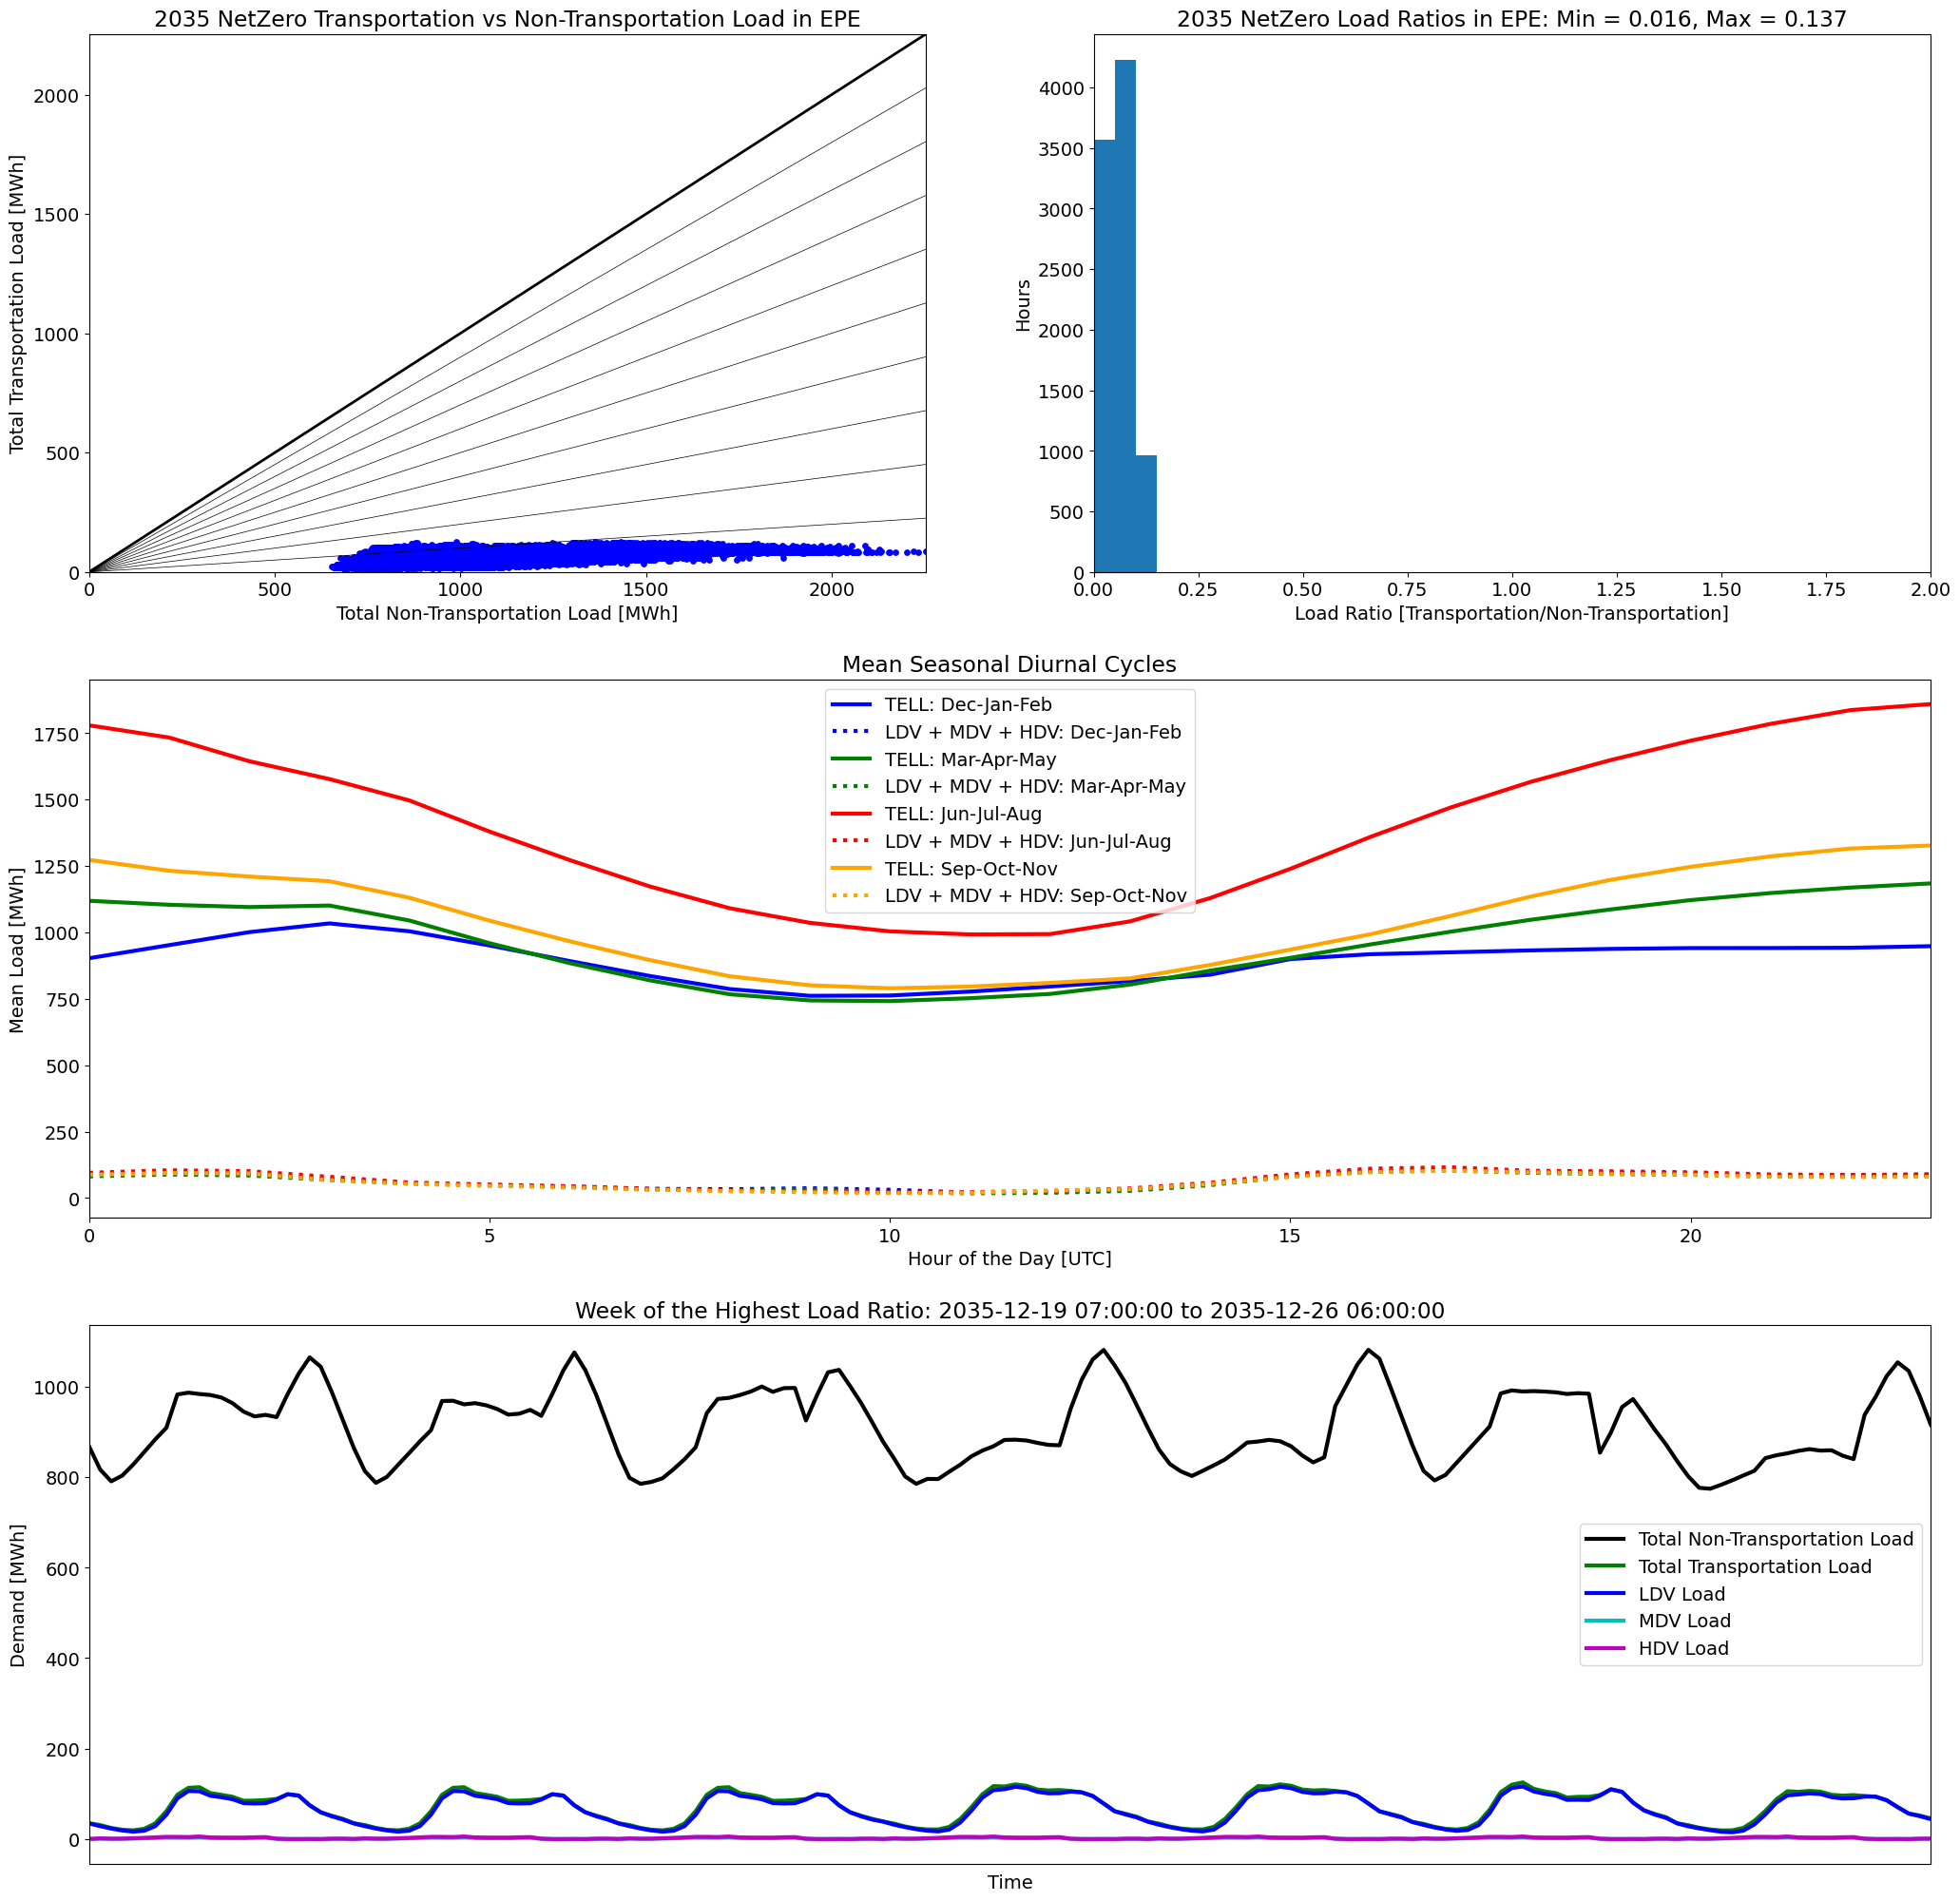

In [51]:
plot_data_comparison(ba_to_plot = 'GCPD',
                     scenario_to_plot = 'NetZero',
                     year_to_plot = '2035', 
                     load_data_input_dir = load_data_input_dir, 
                     trn_data_input_dir = trn_data_input_dir,
                     image_output_dir = image_output_dir,
                     save_images = True)
